# Problem Statement
What is the Circular Error Probable (CEP) for the upcoming drop test of the Electromechanical Recovery System (ERS) under a range of possible scenarios?

# Definition
Loosely speaking, CEP is the mean distance of a sample of points from their mean impact point. That is, a circle around the average point that contains 50% of the sample points. Here, we are defining CEP as the square root of the mean square error, i.e. the sum of range and azimuth variances and their covariance (ignoring bias for now).

# Situation
The ERS will be dropped out of a helicopter somewhere near the McMinnville Airport and for safety and liability reasons, we must have an expectation of the area it may land in. The primary variables we are considering is a range of possible helicopter trajectories (in terms of velocity and heading, with positions randomized around a certain mean) as well as a range of likely wind conditions (also as velocities and headings). GPS error is accounted for in the final calculation.

There are three wind conditions and four operational modes (that is, three failure modes and a successful mission) to consider, giving us a total of 12 scenarios to examine.

We consider the case where the helicopter flies with the wind and expect this to be our worst case for spread of impacts. We consider the case where the helicopter flies orthogonal to the wind. We consider the case where the helicopter flies against the wind and expect this to be a best case scenario for minimizing distance travelled. It should be noted that each of these cases describes only the mean of a normal distribution in said direction.

We consider the case that the mission is successful. We consider the cases that only the drogue parachute fails and that the ERS system fails completely to be identical, given the distance we drop from. We consider the case that the drogue deploys correctly but remains attached while the main chute does not deploy. We consider the case that the main chute somehow deploys when the drogue is supposed to, which we expect to provide our worst case in terms of CEP spread.

# Methodology
Another Notebook contains a trajectory simulator and our documentation of it. We have reason to believe our model is representative of the actual system and environment, assuming wind may be held constant for up to several minutes. The trajectory is available both as a numerical integration of a system of ordinary differential equations and as a linearization of that integration. In either case, the interaction of the drogue parachute with air must be integrated, but the phases prior to that and after that may be considered as steady-states without loss of significant precision. Hence, we use the linearization of our trajectory model in this Notebook as it is much faster to compute. Our impact points may each be off by up to 20 m, but I don't believe their clustering around the mean will be effected.

If this makes you nervous, change the function call from trajectory_fast() to trajectory() in the 2nd code block and go for a very long walk.

Since CEP relies on observational evidence to calculate, we selected a Monte Carlo simulation of our trajectory model to generate data for statistical analysis. For each of our twelve scenarios, we randomly sample 1,000 trajectories (with random variables considered independently) and we collect every final impact point, along with their initial conditions.

# Conclusions
For the most control over mean impact point and CEP, this analysis suggests travelling against the wind at around 8 meters/second. This initial condition is good in the case of mission success and in our failure modes as well. 

In the case of success, CEP is around 100 m, and in the widest failure mode where the main chute deploys early, it is around 150 m. This suggests that we ought to secure land in a 300-450 m radius around our projected mean impact point.

If we are travelling against the wind in average weather conditions, in the case of mission success the mean impact point will be 45 m behind the point of release, in the case of drogue chute failure, mean impact will be 100 m in front of the origin, and in the case of early deployment of main chute, mean impact will be about 125 m behind the release point. This suggests that in any case, (going against the wind) the mean impact point will be within 125 m of the release point.

Taken together, these two projections suggest that given our assumptions, we can be relatively confident that as long as we are travelling against the wind at around 8 m/s (relative to the ground), the ERS will land somewhere within 500 m of where it is dropped.

In [4]:
%run drop_test_simulator.ipynb
import pandas as pd

Note that this code has been written with a lot of generality to make it easier to specify later simulations of our various scenarios completely with single lines of code. 

In [4]:
# note that if dt=0.25 the horizontal distance may be off by about 8 m (compared to dt=0.001)
def mc_init(num_sims=500, dt=0.25, wind_worst_case=True, wind_neutral_case=False, mode=''):
    wind_best_case = False if wind_worst_case==True else not wind_neutral_case

    all_coords = []
    v_wind_rndm = []
    v_plane_rndm = []
    init_pos_offset = []

    # note that we are fixing helicopter direction at 135 degrees
    if wind_worst_case:
        deg_wind_mean, deg_wind_std_dev  = (135, 60) # 120 degree cone in direction of travel
    elif wind_best_case:
        deg_wind_mean, deg_wind_std_dev  = (315, 60) # 120 degree cone in direction against travel
    else:
        deg_wind_mean, deg_wind_std_dev  = (225, 90) # 180 degree cone orthogonal to travel

    for i in range(num_sims):
        v_wind_rndm.append([np.random.rayleigh(2.47344), # rayleigh distro good for wind magnitude
                            np.random.normal(deg_wind_mean, deg_wind_std_dev)]) # idk if normal or uniform is best
        
        v_plane_rndm.append(np.random.uniform(0, 18)) # pretend dan flies pseudorandomly
        
        init_pos_offset.append([np.random.normal(0, 30 * 0.3048), # converting feet to meters
                                np.random.normal(0, 30 * 0.3048),
                                np.random.normal(0, 15 * 0.3048)]) # account for the imperfections of reality
    print('random wind and helicopter vectors obtained\n')

    for i, vw in enumerate(v_wind_rndm):
        all_coords.append(trajectory_fast(v_plane=v_plane_rndm[i],
                                          v_wind=vw[0],
                                          deg_wind=vw[1],
                                          x_0_offset=init_pos_offset[i],
                                          mode=mode,
                                          dt=0.25)[0])
        if i % 250 == 0: print('iterations:', i)
    print('done simulations!\n')
    
    return (all_coords, v_wind_rndm, v_plane_rndm)

In [5]:
def handle_data(all_coords, v_wind_rndm, v_plane_rndm):
    # landing coordinates
    results_df = pd.DataFrame.from_records(all_coords, columns=['x','y'])
    # magnitude of landing coordinate
    results_df['norm'] = results_df.apply(np.linalg.norm, axis=1, raw=True)
    # azimuth angle of landing (note that this is on the unit circle)
    results_df['theta'] = results_df.apply(lambda pos: np.arctan2(pos[1], pos[0]), axis=1, raw=True)
    # plane velocities
    results_df['v_plane'] = [vel for vel in v_plane_rndm]
    # wind magnitude
    results_df['v_w'] = [vel[0] for vel in v_wind_rndm]
    # wind direction (is this on unit circle? need to think more...)
    results_df['deg_w'] = [vel[1] for vel in v_wind_rndm]

    print(results_df.describe())
    return results_df

In [5]:
def visualize(results_df):
    # these are not the means of the coordinates, taken individually
    # this is the coordinate of the mean impact point, hence the polar coordinates
    mean_x = results_df.apply(lambda pos: pos[2] * np.cos(pos[3]), axis=1, raw=True).describe()['mean']
    mean_y = results_df.apply(lambda pos: pos[2] * np.sin(pos[3]), axis=1, raw=True).describe()['mean']
    print('Mean Impact: (', mean_x, ',', mean_y, ')')

    # assume that the bias is 0 until we have an actual target point
    # so CEP = sqrt(MSE) = sqrt(var_norm + var_theta + cov_norm_theta)
    # this is the mean distance from the mean impact point
    variance = results_df.var(axis=0)[2:4].sum()
    covariance = results_df.cov().iloc[2, 3]
    # GPS is 95% inside a 2x2 m box, and 95% of values on one axis are within 2*RMS of ideal
    # thus RMS = 1/2, since 2* 1/2 =1, and 1 on each side gives a 2 m bound. Therefore MSE = 1/4, which we double
    # because there are two axes to account for
    GPS_MSE = 1/4
    bias = 0
    total_MSE = variance + covariance + bias + 2*GPS_MSE
    CEP = np.sqrt(total_MSE)
    print('CEP:', CEP.round(3), 'm')

    plt.figure(1)
    plt.hist2d(results_df['v_w'], results_df['deg_w'], 25)
    plt.title('wind vectors')
    plt.xlabel('v (m/s)')
    plt.ylabel('direction (degrees)')
    plt.show()

    plt.figure(2)
    plt.hist(results_df['v_w'], 30)
    plt.xlabel('wind magnitude (m/s)')
    plt.ylabel('count')
    plt.title('wind speed distribution')
    plt.show()

    plt.figure(3)
    plt.hist(results_df['norm'], 30)
    plt.title('distances from origin')
    plt.xlabel('radius (m)')
    plt.ylabel('count')
    plt.show()

    plt.figure(4)
    plt.hist2d(results_df['x'],results_df['y'], 30)
    plt.plot(mean_x, mean_y, 'r^')
    plt.title('landing sites')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.show()

    plt.figure(5)
    results_df.plot.scatter('x', 'y', s=1, c='v_plane', colormap='inferno')
    plt.axis('equal')
    circle1 = plt.Circle((mean_x, mean_y), CEP, color='r', fill=False)
    circle2 = plt.Circle((mean_x, mean_y), 2*CEP, color='tab:orange', fill=False)
    circle3 = plt.Circle((mean_x, mean_y), 3*CEP, color='y', fill=False)
    plt.gca().add_artist(circle1)
    plt.gca().add_artist(circle2)
    plt.gca().add_artist(circle3)
    plt.title('impact points (and initial helicopter velocities)')

    plt.figure(6)
    results_df.plot.scatter('x', 'y', s=1, c='v_w', colormap='inferno')
    plt.axis('equal')
    circle1 = plt.Circle((mean_x, mean_y), CEP, color='r', fill=False)
    circle2 = plt.Circle((mean_x, mean_y), 2*CEP, color='tab:orange', fill=False)
    circle3 = plt.Circle((mean_x, mean_y), 3*CEP, color='y', fill=False)
    plt.gca().add_artist(circle1)
    plt.gca().add_artist(circle2)
    plt.gca().add_artist(circle3)
    plt.title('impact points (and initial wind velocities)')
    
    return ((mean_x, mean_y), CEP)

In [7]:
# mission success
worst_coords, worst_wind, worst_plane = mc_init(num_sims=1000, dt=0.25, wind_worst_case=True, wind_neutral_case=False)
neut_coords, neut_wind, neut_plane = mc_init(num_sims=1000, dt=0.25, wind_worst_case=False, wind_neutral_case=True)
best_coords, best_wind, best_plane = mc_init(num_sims=1000, dt=0.25, wind_worst_case=False, wind_neutral_case=False)

# main chute failure
worst_coords_A, worst_wind_A, worst_plane_A = mc_init(num_sims=1000, dt=0.25, wind_worst_case=True, wind_neutral_case=False, mode='A')
neut_coords_A, neut_wind_A, neut_plane_A = mc_init(num_sims=1000, dt=0.25, wind_worst_case=False, wind_neutral_case=True, mode='A')
best_coords_A, best_wind_A, best_plane_A = mc_init(num_sims=1000, dt=0.25, wind_worst_case=False, wind_neutral_case=False, mode='A')

# drogue failure
worst_coords_B, worst_wind_B, worst_plane_B = mc_init(num_sims=1000, dt=0.25, wind_worst_case=True, wind_neutral_case=False, mode='B')
neut_coords_B, neut_wind_B, neut_plane_B = mc_init(num_sims=1000, dt=0.25, wind_worst_case=False, wind_neutral_case=True, mode='B')
best_coords_B, best_wind_B, best_plane_B = mc_init(num_sims=1000, dt=0.25, wind_worst_case=False, wind_neutral_case=False, mode='B')

# early deployment
worst_coords_C, worst_wind_C, worst_plane_C = mc_init(num_sims=1000, dt=0.25, wind_worst_case=True, wind_neutral_case=False, mode='C')
neut_coords_C, neut_wind_C, neut_plane_C = mc_init(num_sims=1000, dt=0.25, wind_worst_case=False, wind_neutral_case=True, mode='C')
best_coords_C, best_wind_C, best_plane_C = mc_init(num_sims=1000, dt=0.25, wind_worst_case=False, wind_neutral_case=False, mode='C')

random wind and helicopter vectors obtained

iterations: 0
iterations: 250
iterations: 500
iterations: 750
done simulations!

random wind and helicopter vectors obtained

iterations: 0
iterations: 250
iterations: 500
iterations: 750
done simulations!

random wind and helicopter vectors obtained

iterations: 0
iterations: 250
iterations: 500
iterations: 750
done simulations!

random wind and helicopter vectors obtained

iterations: 0
iterations: 250
iterations: 500
iterations: 750
done simulations!

random wind and helicopter vectors obtained

iterations: 0
iterations: 250
iterations: 500
iterations: 750
done simulations!

random wind and helicopter vectors obtained

iterations: 0
iterations: 250
iterations: 500
iterations: 750
done simulations!

random wind and helicopter vectors obtained

iterations: 0
iterations: 250
iterations: 500
iterations: 750
done simulations!

random wind and helicopter vectors obtained

iterations: 0
iterations: 250
iterations: 500
iterations: 750
done simula

### Note that the following plots are not normalized so visual comparison must take their differing scales into account. Please recall that the helicopter is travelling in the positive Y direction.

# Analysis of Mission Success
In all of these scenarios, I can't distinguish any patterns in impact points with respect to initial plane velocity. However, it seems obvious that the spread is highly determined by initial wind velocity. This shouldn't be too surprising since during most of the main chute phase, the system is in a steady state. For low wind velocities, the impacts are more clustered and they spread out as that velocity increases.

The CEP is in the same ballpark for each wind condition which suggests that the relative distribution of impact points depends more on the system than the environment. However, the location of the mean impact point depends heavily on the wind condition. The worst case is more than twice as far as the neutral case, which is a little less than half as far as the best case. Interestingly, in the worst and neutral cases, the final impact is in the direction of initial motion of helicopter and wind, but in the best case the wind counteracts the initial momentum and carries the system to a point slightly behind the release point.

This suggests that it is ideal to fly against the wind so that the ERS is not carried further from the drop point than it needs to be.
## In Worst Case of flying with the wind
Mean Impact: ( 0.12007520037151699 , 163.57222630570556 )

CEP: 100.841 m
## In Neutral Case of flying orthogonal the wind
Mean Impact: ( -50.24672046354343 , 57.44936413361679 )

CEP: 105.771 m
## In Best Case of flying against the wind
Mean Impact: ( 2.911293301944554 , -45.28102453829501 )

CEP: 95.438 m

                 x            y         norm        theta      v_plane  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.120075   163.572226   223.221358     1.341587     8.766307   
std     134.108278   123.561115   100.783914     1.083259     5.232834   
min    -418.286672  -356.262811     5.103455    -3.127627     0.027324   
25%     -82.307575    93.712469   149.759281     1.008609     4.181570   
50%      -0.649785   162.704859   211.379304     1.505108     8.564142   
75%      85.123983   233.938699   291.483277     1.969146    13.285338   
max     477.397214   646.012623   650.187851     3.138529    17.997727   

               v_w        deg_w  
count  1000.000000  1000.000000  
mean      3.071435   134.629863  
std       1.624341    59.014368  
min       0.045304   -62.321403  
25%       1.801810    96.742917  
50%       2.900411   135.132586  
75%       4.135766   173.392845  
max      10.196298   347.660924  
Mean Impact: ( 0.1200752003

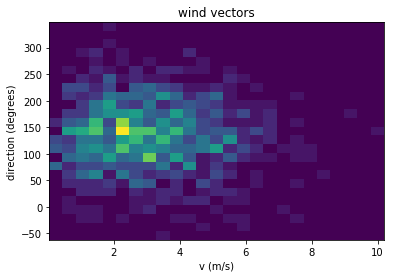

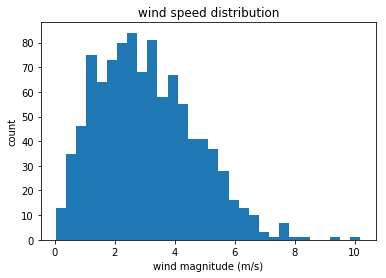

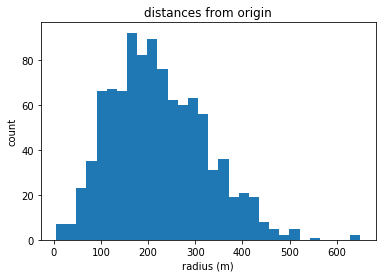

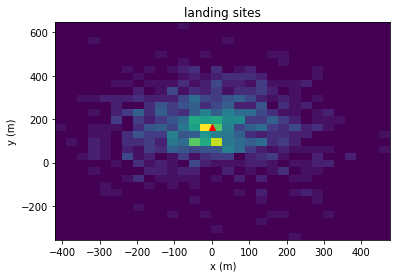

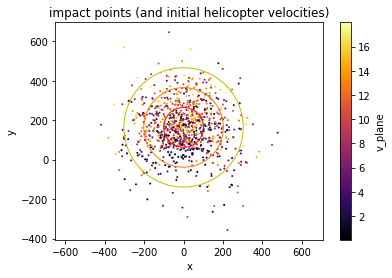

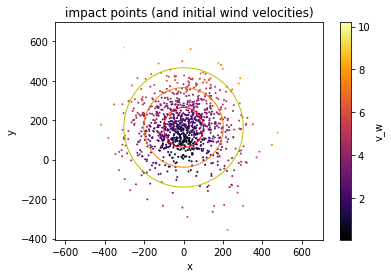

In [9]:
worst_data = handle_data(worst_coords, worst_wind, worst_plane)
worst_pos, worst_CEP = visualize(worst_data)

                 x            y         norm        theta      v_plane  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean    -50.246720    57.449364   197.087563     0.601007     8.885471   
std     147.572804   149.813417   105.690092     1.975540     5.161321   
min    -602.431493  -466.398614     8.543296    -3.138824     0.015364   
25%    -140.696452   -37.949785   117.605147    -1.204561     4.427003   
50%     -53.921760    53.269515   184.104425     1.335927     9.000627   
75%      33.978734   153.376781   264.825576     2.209850    13.355470   
max     453.099255   553.423816   648.124662     3.141434    17.984006   

               v_w        deg_w  
count  1000.000000  1000.000000  
mean      3.093441   225.516788  
std       1.686650    90.291316  
min       0.088582   -78.909497  
25%       1.842089   163.901788  
50%       2.872314   226.296697  
75%       4.138614   282.413826  
max      10.287805   518.310638  
Mean Impact: ( -50.24672046

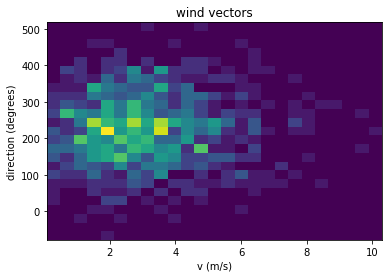

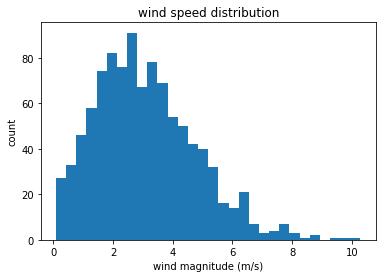

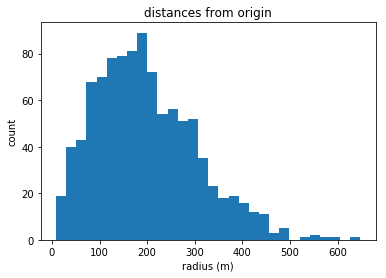

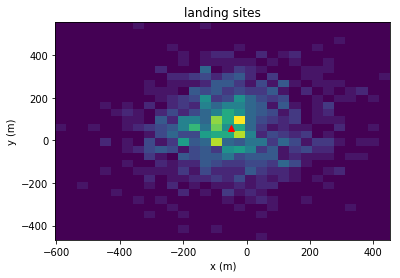

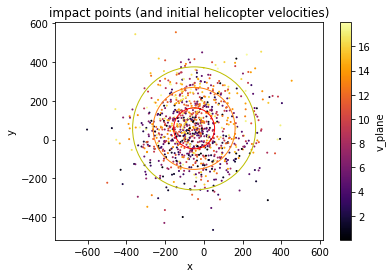

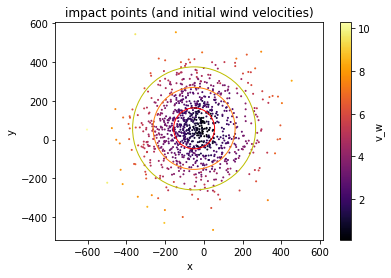

In [10]:
neut_data = handle_data(neut_coords, neut_wind, neut_plane)
neut_pos, neut_CEP = visualize(neut_data)

                 x            y         norm        theta      v_plane  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      2.911293   -45.281025   158.534252    -0.363281     9.110381   
std     136.195164   116.918665    95.507785     1.798149     5.216366   
min    -477.869289  -392.991562     4.288854    -3.128658     0.006815   
25%     -79.032191  -118.917269    86.774350    -1.813826     4.529342   
50%      -2.597490   -36.914429   145.012890    -0.706019     9.252797   
75%      87.090183    30.073436   217.094000     0.764259    13.461974   
max     411.632986   374.314728   479.607886     3.139128    17.986325   

               v_w        deg_w  
count  1000.000000  1000.000000  
mean      2.961632   314.646398  
std       1.613723    60.327521  
min       0.052097   101.652094  
25%       1.696341   272.601713  
50%       2.793870   312.889357  
75%       4.033396   356.050937  
max       8.441057   481.523079  
Mean Impact: ( 2.9112933019

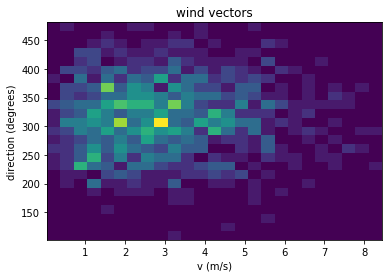

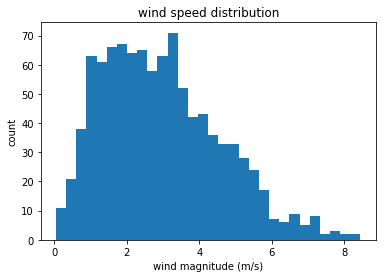

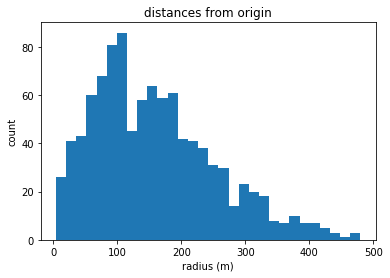

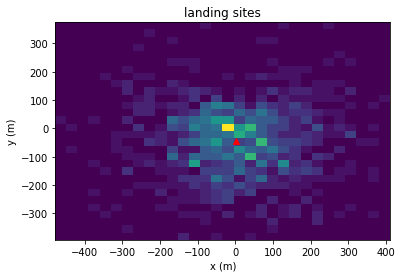

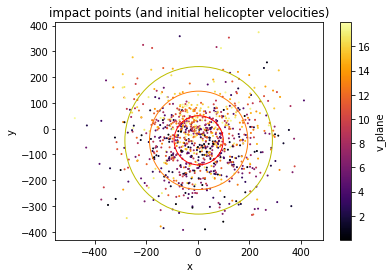

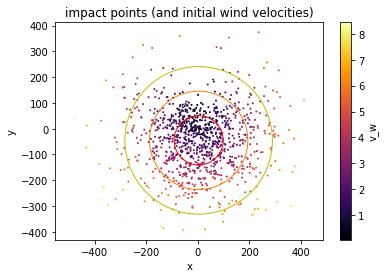

In [11]:
best_data = handle_data(best_coords, best_wind, best_plane)
best_pos, best_CEP = visualize(best_data)

# Analysis of Main Chute Failure (with successful Drogue Deployment)
In all of these cases, a similar pattern of wind velocity determining final position seems evident, although to a lesser extent. Interestingly, the helicopter velocity appears to play some role in these cases. Particularly high or low velocities may take the ERS out of the CEP range which suggests maybe a 6-10 m/s ideal helicopter speed.

CEP in the worst and neutral cases are equivalent but it is significantly better in the best case. Again, the range of mean impact in the worst case is further than the neutral case, and in the best case the initial velocity of the helicopter is neatly canceled by the wind. This reinforces our analysis of mission success but cautions us to fly somewhere between 4 to 12 m/s as the extremities of our window.
## In Worst Case of flying with the wind
Mean Impact: ( -1.8028827080878131 , 99.5907284792352 )

CEP: 49.441 m
## In Neutral Case of flying orthogonal the wind
Mean Impact: ( -21.83052172096882 , 56.76574789132798 )

CEP: 50.983 m
## In Best Case of flying against the wind
Mean Impact: ( 3.0183931720545734 , 13.423331273306259 )

CEP: 38.514 m

                 x            y         norm        theta      v_plane  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     -1.802883    99.590728   117.618098     1.473251     9.090537   
std      55.864464    56.863682    49.375571     0.816908     5.343568   
min    -172.798710   -84.107364    10.227712    -3.077190     0.005169   
25%     -36.363061    59.655191    80.666322     1.212028     4.478629   
50%       1.512366    98.148809   113.717893     1.542218     9.174318   
75%      32.640033   139.109145   149.577832     1.901731    13.911302   
max     173.221138   276.040799   277.850965     3.116840    17.980423   

               v_w        deg_w  
count  1000.000000  1000.000000  
mean      3.059037   134.407867  
std       1.590279    60.377645  
min       0.171607   -41.674457  
25%       1.853433    96.259384  
50%       2.866487   133.371600  
75%       4.094220   176.617900  
max       8.849660   358.626886  
Mean Impact: ( -1.802882708

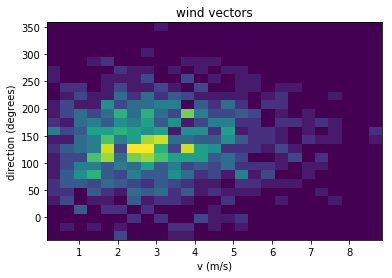

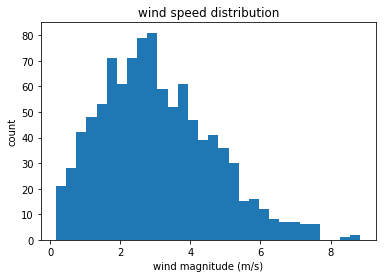

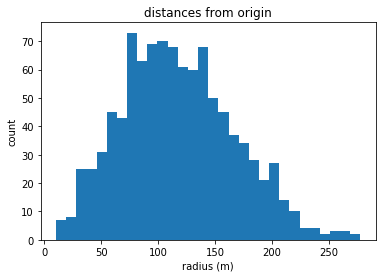

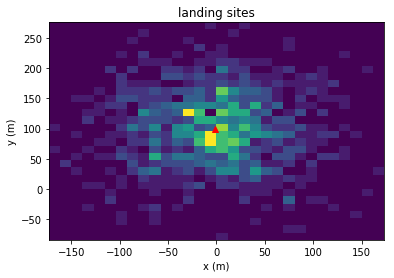

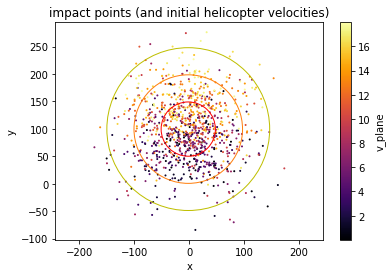

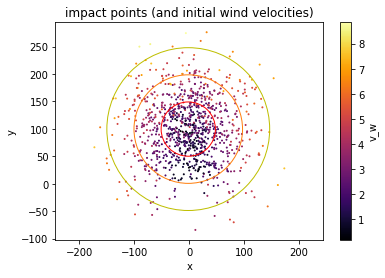

In [12]:
worst_data_A = handle_data(worst_coords_A, worst_wind_A, worst_plane_A)
worst_pos_A, worst_CEP_A = visualize(worst_data_A)

                 x            y         norm        theta      v_plane  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean    -21.830522    56.765748    95.638108     1.002834     9.031220   
std      57.142626    69.028171    50.764053     1.736820     5.103553   
min    -211.096676  -142.250213     2.361483    -3.140454     0.102771   
25%     -58.689729     9.750628    56.965914     0.492582     4.710658   
50%     -23.058982    54.350654    90.673482     1.635842     9.232202   
75%      10.650176   105.336195   128.705495     2.171151    13.448435   
max     165.750932   259.049929   272.857349     3.108288    17.969193   

               v_w        deg_w  
count  1000.000000  1000.000000  
mean      3.103079   223.136330  
std       1.666839    87.857273  
min       0.146232   -39.447747  
25%       1.787114   162.754096  
50%       2.985144   225.366209  
75%       4.167945   283.345218  
max       9.112139   481.344802  
Mean Impact: ( -21.83052172

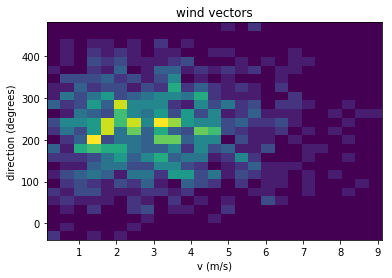

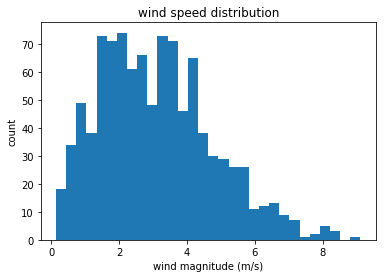

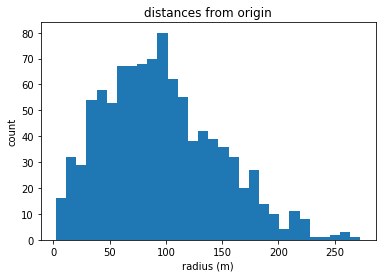

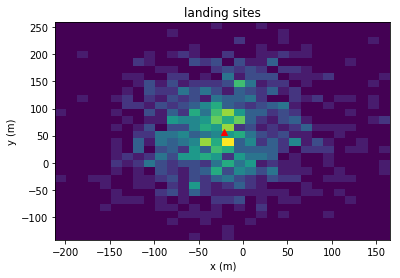

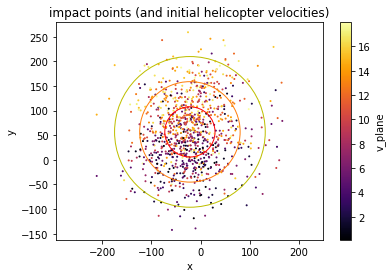

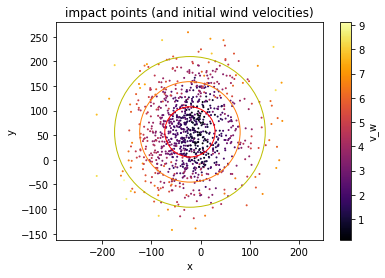

In [13]:
neut_data_A = handle_data(neut_coords_A, neut_wind_A, neut_plane_A)
neut_pos_A, neut_CEP_A = visualize(neut_data_A)

                 x            y         norm        theta      v_plane  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      3.018393    13.423331    69.647417     0.357067     9.039828   
std      54.034461    56.752079    38.397775     1.720463     5.210170   
min    -205.547657  -162.376633     3.981270    -3.135507     0.023896   
25%     -31.885796   -22.756164    41.234379    -1.047397     4.639253   
50%       2.684650    15.088411    65.983421     0.626499     9.044976   
75%      38.922794    51.841423    91.443730     1.792243    13.567272   
max     173.115795   209.614727   214.439281     3.139696    17.974161   

               v_w        deg_w  
count  1000.000000  1000.000000  
mean      3.019467   318.032373  
std       1.638697    59.801595  
min       0.022035   111.275355  
25%       1.850957   279.763261  
50%       2.841451   319.798042  
75%       4.029258   359.058567  
max       9.110618   472.461093  
Mean Impact: ( 3.0183931720

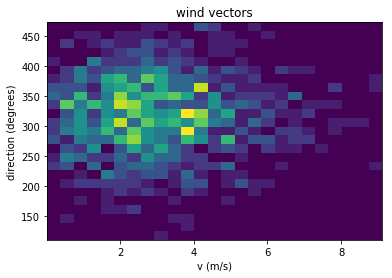

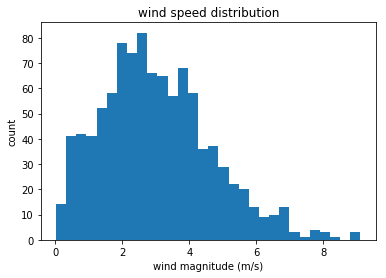

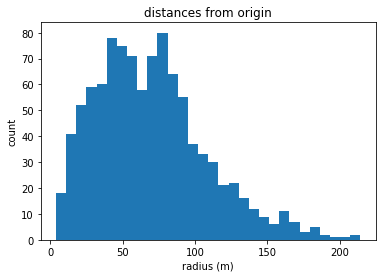

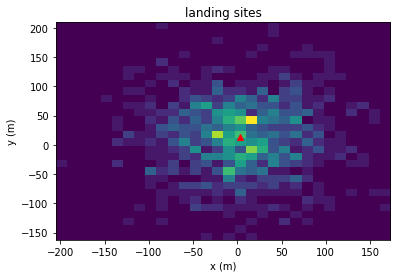

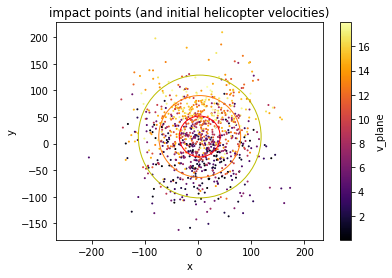

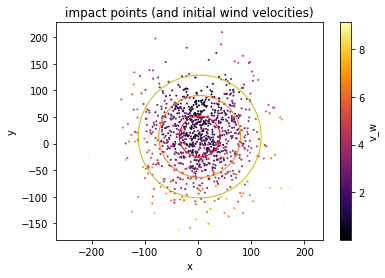

In [14]:
best_data_A = handle_data(best_coords_A, best_wind_A, best_plane_A)
best_pos_A, best_CEP_A = visualize(best_data_A)

# Analysis of Drogue Failure
There's not much to say about this case. The wind has almost no effect without parachutes, so both our mean impact point and CEP remains equivalent in all three cases. That being said, we should keep in mind that if there is a total system failure, the system will fly and land somewhere in basically one direction. So we should probably not drop the system towards anything valuable even if we expect the wind to take it elsewhere.

Obviously since wind has no effect, our mean impact point is a function of helicopter velocity, and so (keeping in mind the previous analysis) we should probably aim for somewhere around 8 m/s to have the best idea of what happens if everything goes wrong.
## In Worst Case of flying with the wind
Mean Impact: ( 0.10015029490141075 , 104.1404795984714 )

CEP: 58.283 m
## In Neutral Case of flying orthogonal the wind
Mean Impact: ( 0.2636774360421865 , 103.58008248917776 )

CEP: 57.62 m
## In Best Case of flying against the wind
Mean Impact: ( 0.41261415620862507 , 100.0164705471085 )

CEP: 58.009 m

                 x            y         norm        theta      v_plane  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.100150   104.140480   105.088539     1.521159     9.327399   
std       9.449524    59.166798    58.236186     0.465393     5.253284   
min     -28.619367   -17.519616     3.056053    -3.040268     0.003961   
25%      -6.737518    56.124612    57.474445     1.499780     4.899313   
50%      -0.245846   104.334961   104.600879     1.571794     9.429511   
75%       6.582790   155.537425   155.763052     1.639859    14.029490   
max      27.447010   233.539409   233.590400     3.127593    17.972807   

               v_w        deg_w  
count  1000.000000  1000.000000  
mean      3.194157   137.166224  
std       1.670090    61.869552  
min       0.033461   -56.034123  
25%       1.925798    94.897251  
50%       2.948692   136.997251  
75%       4.223658   178.254661  
max       9.199526   307.735554  
Mean Impact: ( 0.1001502949

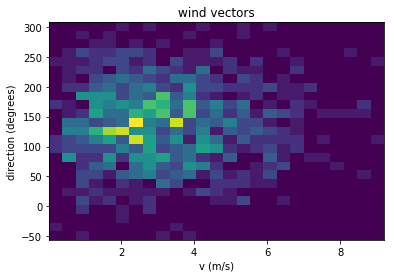

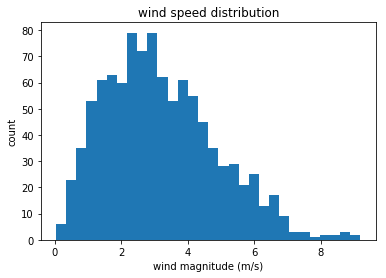

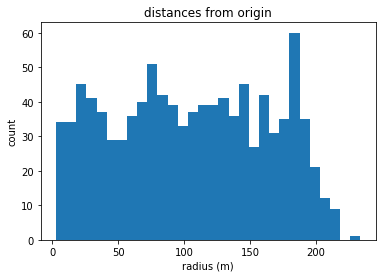

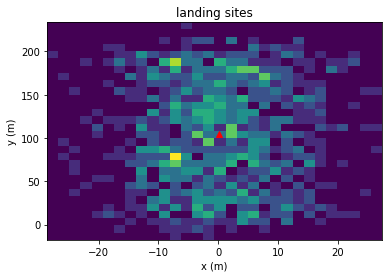

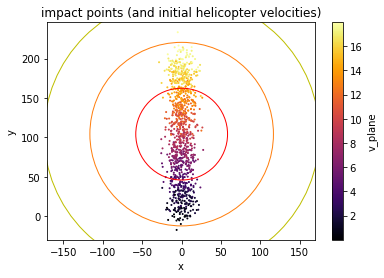

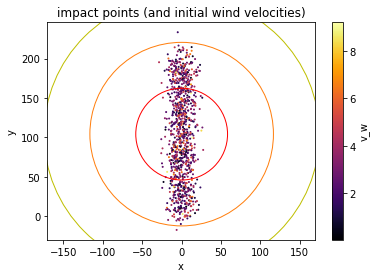

In [15]:
worst_data_B = handle_data(worst_coords_B, worst_wind_B, worst_plane_B)
worst_pos_B, worst_CEP_B = visualize(worst_data_B)

                 x            y         norm        theta      v_plane  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.263677   103.580082   104.515933     1.529181     9.297417   
std       9.204315    58.530754    57.582086     0.413946     5.138635   
min     -33.998364   -16.333897     1.011046    -2.410791     0.017586   
25%      -6.007278    54.198834    54.813766     1.499758     4.870530   
50%       0.449608   106.853320   107.103740     1.565747     9.455815   
75%       6.334418   153.391676   153.622329     1.630336    13.566496   
max      31.644838   215.114745   215.288768     3.071970    17.991964   

               v_w        deg_w  
count  1000.000000  1000.000000  
mean      3.063221   225.153273  
std       1.648006    88.721149  
min       0.071107   -95.167661  
25%       1.802988   164.342308  
50%       2.815775   225.365621  
75%       4.036950   287.460052  
max      10.265946   545.426592  
Mean Impact: ( 0.2636774360

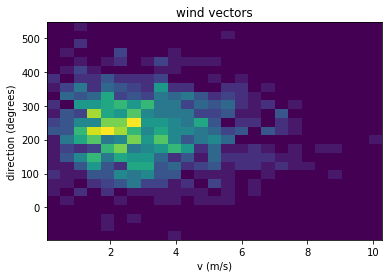

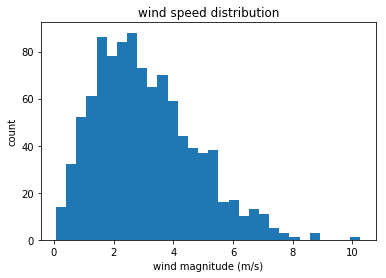

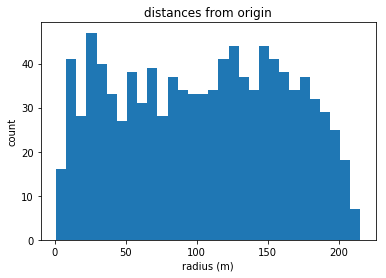

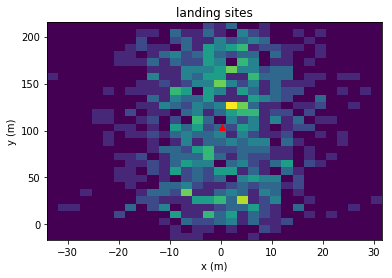

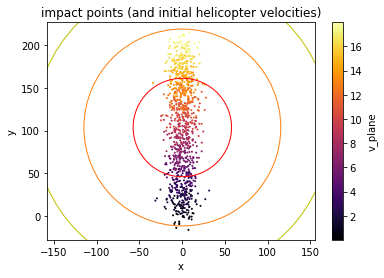

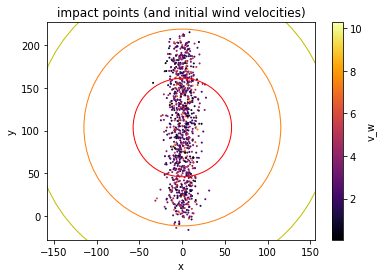

In [16]:
neut_data_B = handle_data(neut_coords_B, neut_wind_B, neut_plane_B)
neut_pos_B, neut_CEP_B = visualize(neut_data_B)

                 x            y         norm        theta      v_plane  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.412614   100.016471   101.156813     1.495318     8.989778   
std       9.057500    59.204111    57.945659     0.545530     5.202231   
min     -28.827596   -12.266233     1.942165    -2.998916     0.001278   
25%      -5.790598    47.911797    49.715561     1.496895     4.499649   
50%       0.353248   102.586688   102.716979     1.565845     9.118521   
75%       6.183185   148.869970   149.105365     1.629516    13.408378   
max      30.769513   219.102670   219.139927     3.040235    17.999501   

               v_w        deg_w  
count  1000.000000  1000.000000  
mean      3.079481   317.215154  
std       1.599150    58.671882  
min       0.130955   110.735820  
25%       1.909785   278.973016  
50%       2.909942   319.919010  
75%       4.064657   357.031564  
max       9.536805   510.633572  
Mean Impact: ( 0.4126141562

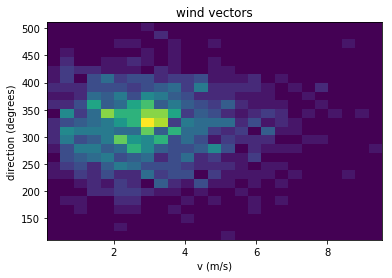

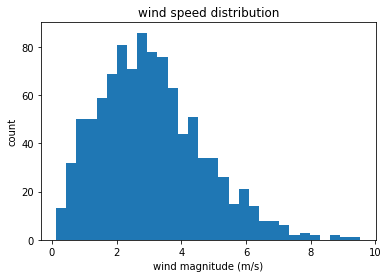

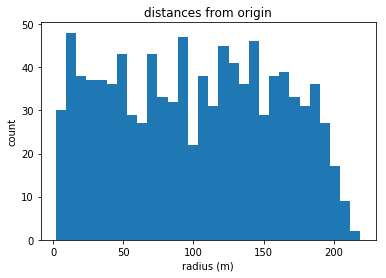

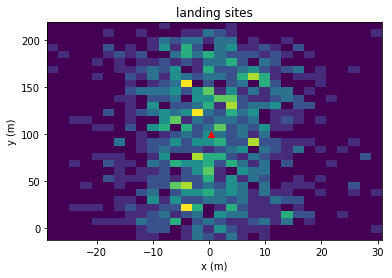

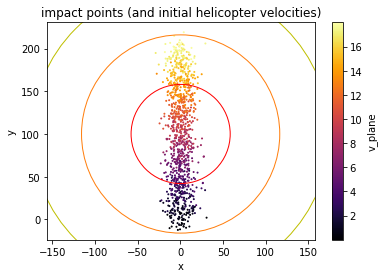

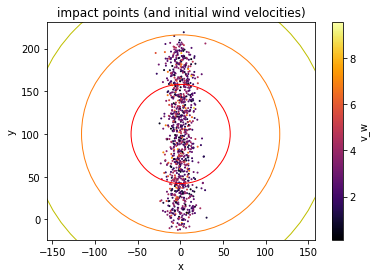

In [17]:
best_data_B = handle_data(best_coords_B, best_wind_B, best_plane_B)
best_pos_B, best_CEP_B = visualize(best_data_B)

# Analysis of Main Chute Early Deployment (with Drogue Failure)
Similarly to the case of mission success, final impact points are determined almost entirely by wind conditions and barely at all by plane velocity. This seems almost exactly the same as that case only on a larger scale, with both further impact ranges and wider CEP. CEP doesn't change between the cases, but this simulation reinforces the message that we should not fly with the wind. The range of the mean impact point doesn't change much between the neutral and best case, perhaps given the additional time in the air the initial conditions of the helicopter are completely dominated by wind.

Thus if we are flying against the wind we should probably clear a significant amount of the land behind us, i.e. don't fly over anything valuable before dropping the ERS. 
## In Worst Case of flying with the wind
Mean Impact: ( 4.973629606127457 , 208.03121062586004 )

CEP: 149.172 m
## In Neutral Case of flying orthogonal the wind
Mean Impact: ( -89.07312836323936 , 60.74537843356962 )

CEP: 149.445 m
## In Best Case of flying against the wind
Mean Impact: ( 3.4481476387843077 , -125.55733207500211 )

CEP: 149.089 m

                 x            y         norm        theta      v_plane  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      4.973630   208.031211   314.042463     1.248854     9.213748   
std     212.029669   180.740177   149.155183     1.214206     5.160023   
min    -661.011643  -507.917216    13.094280    -3.135549     0.017953   
25%    -135.579806    99.176532   202.624211     0.831973     4.715420   
50%       6.048201   205.738842   299.081307     1.447068     9.186269   
75%     144.163736   314.648259   407.047117     1.993785    13.727482   
max     780.206896   831.026263   834.580476     3.139738    17.955087   

               v_w        deg_w  
count  1000.000000  1000.000000  
mean      3.141358   132.949659  
std       1.624455    60.067320  
min       0.053971   -67.039356  
25%       1.931906    95.962364  
50%       2.963383   132.685189  
75%       4.143487   172.500924  
max       8.850663   326.692870  
Mean Impact: ( 4.9736296061

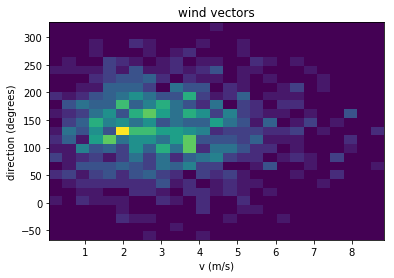

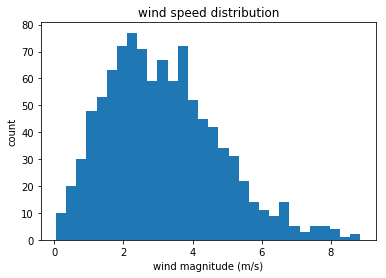

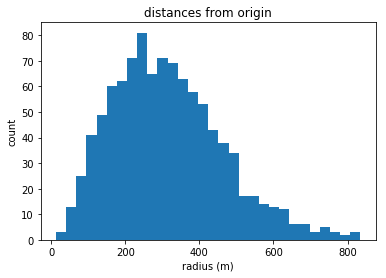

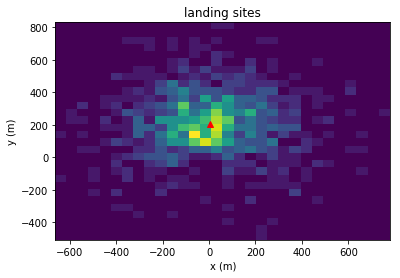

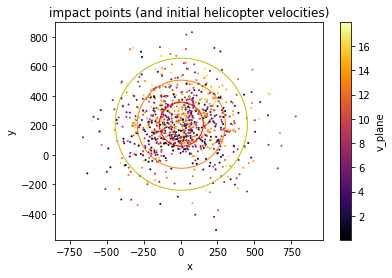

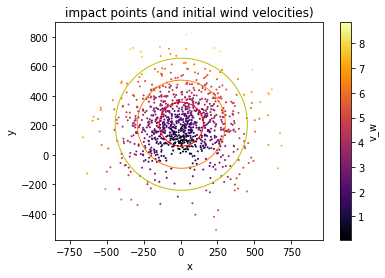

In [18]:
worst_data_C = handle_data(worst_coords_C, worst_wind_C, worst_plane_C)
worst_pos_C, worst_CEP_C = visualize(worst_data_C)

                 x            y         norm        theta      v_plane  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean    -89.073128    60.745378   292.910000     0.348109     9.287451   
std     205.145104   233.379660   149.345531     2.087003     5.215135   
min    -749.617939  -673.070085     9.708697    -3.132742     0.005574   
25%    -218.535360  -100.879576   179.015649    -1.891653     4.798145   
50%    -104.635179    59.421515   275.005876     1.081248     9.669807   
75%      31.804739   219.219632   390.218495     2.198706    13.834330   
max     599.998558   779.494337   840.058311     3.134500    17.986066   

               v_w        deg_w  
count  1000.000000  1000.000000  
mean      3.148978   216.817335  
std       1.610885    88.402694  
min       0.042167   -86.578807  
25%       1.885891   157.399771  
50%       2.969141   216.224554  
75%       4.155835   275.913756  
max       8.795461   507.773055  
Mean Impact: ( -89.07312836

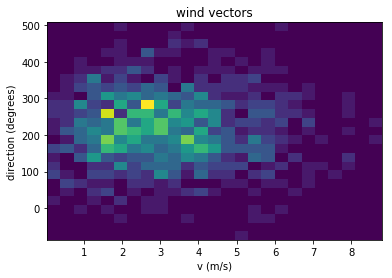

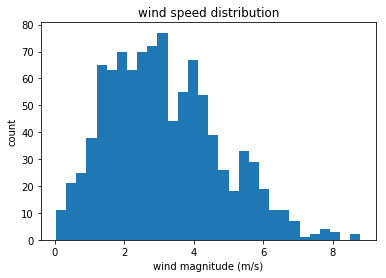

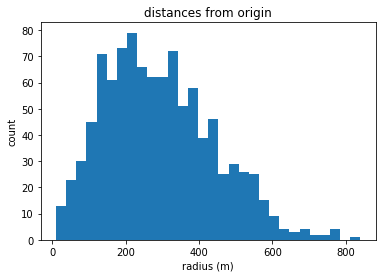

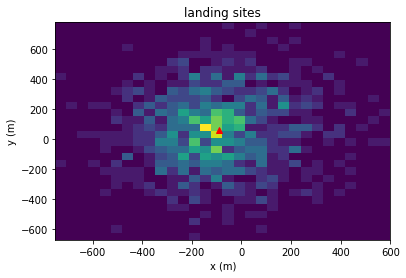

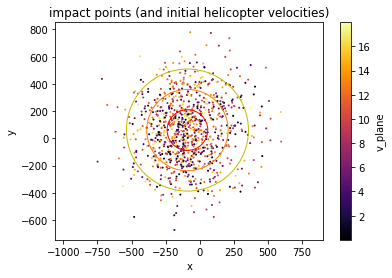

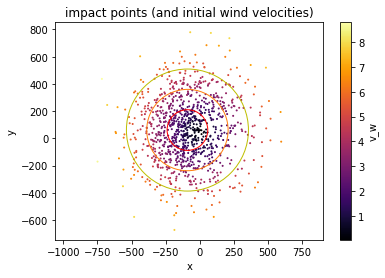

In [19]:
neut_data_C = handle_data(neut_coords_C, neut_wind_C, neut_plane_C)
neut_pos_C, neut_CEP_C = visualize(neut_data_C)

                 x            y         norm        theta      v_plane  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      3.448148  -125.557332   265.844598    -0.856186     8.697724   
std     218.688342   171.370314   149.132849     1.605917     5.090808   
min    -745.007869  -784.616396    13.194490    -3.139824     0.018645   
25%    -136.500337  -222.570845   154.130549    -2.049479     4.448330   
50%      -1.080007  -117.055106   243.865247    -1.153845     8.414661   
75%     147.340035   -17.469869   355.632095    -0.179626    13.025481   
max     712.042609   657.704829   960.576339     3.128083    17.991271   

               v_w        deg_w  
count  1000.000000  1000.000000  
mean      3.136563   315.498058  
std       1.638887    60.123673  
min       0.061495    91.214646  
25%       1.932557   274.621803  
50%       2.906034   313.605800  
75%       4.154485   358.902041  
max      10.531953   510.734208  
Mean Impact: ( 3.4481476387

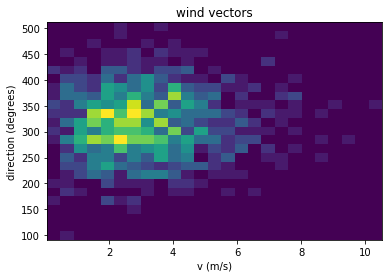

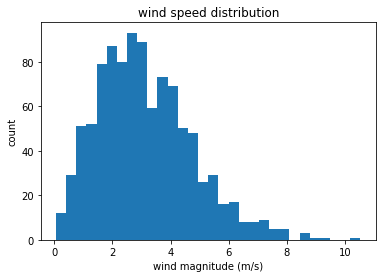

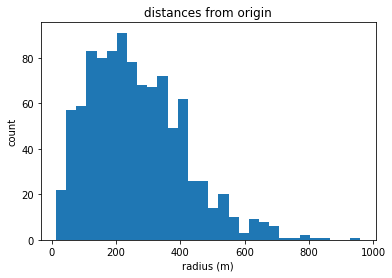

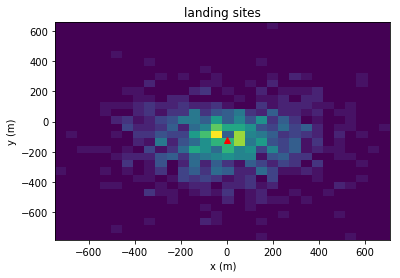

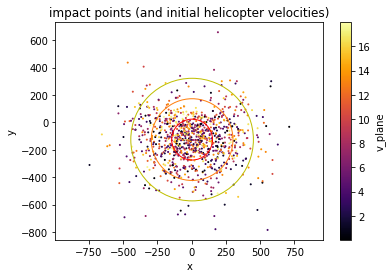

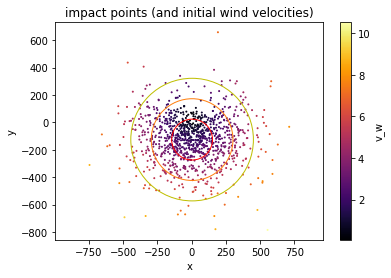

In [20]:
best_data_C = handle_data(best_coords_C, best_wind_C, best_plane_C)
best_pos_C, best_CEP_C = visualize(best_data_C)

In [21]:
worst_data.to_csv(path_or_buf='./worst_data.csv')
neut_data.to_csv(path_or_buf='./neut_data.csv')
best_data.to_csv(path_or_buf='./best_data.csv')

worst_data_A.to_csv(path_or_buf='./worst_data_A.csv')
neut_data_A.to_csv(path_or_buf='./neut_data_A.csv')
best_data_A.to_csv(path_or_buf='./best_data_A.csv')

worst_data_B.to_csv(path_or_buf='./worst_data_B.csv')
neut_data_B.to_csv(path_or_buf='./neut_data_B.csv')
best_data_B.to_csv(path_or_buf='./best_data_B.csv')

worst_data_C.to_csv(path_or_buf='./worst_data_C.csv')
neut_data_C.to_csv(path_or_buf='./neut_data_C.csv')
best_data_C.to_csv(path_or_buf='./best_data_C.csv')

In [18]:
aggregate = pd.concat(map(pd.read_csv, ['worst_data.csv', 'worst_data_A.csv', 'worst_data_B.csv', 'worst_data_C.csv',
                 'neut_data.csv', 'neut_data_A.csv', 'neut_data_B.csv', 'neut_data_C.csv',
                 'best_data.csv', 'best_data_A.csv', 'best_data_B.csv', 'best_data_C.csv']))

In [19]:
aggregate.drop('Unnamed: 0', axis='columns', inplace=True)
print(aggregate.describe())

                  x             y          norm         theta       v_plane  \
count  12000.000000  12000.000000  12000.000000  12000.000000  12000.000000   
mean     -12.308773     66.373055    170.442095      0.808242      9.061438   
std      132.831143    151.723024    127.154740      1.609507      5.195733   
min     -749.617939   -784.616396      1.011046     -3.140454      0.001278   
25%      -59.156691     -1.727876     79.958066     -0.050388      4.575878   
50%       -3.110431     71.921930    140.117700      1.484174      9.143078   
75%       28.704900    148.931684    221.391591      1.778760     13.529444   
max      780.206896    831.026263    960.576339      3.141434     17.999501   

                v_w         deg_w  
count  12000.000000  12000.000000  
mean       3.089321    224.597443  
std        1.634924    102.616009  
min        0.022035    -95.167661  
25%        1.847818    142.946292  
50%        2.893447    224.340371  
75%        4.117416    305.273883  


Mean Impact: ( -12.308772704117066 , 66.3730552636735 )
CEP: 127.102 m


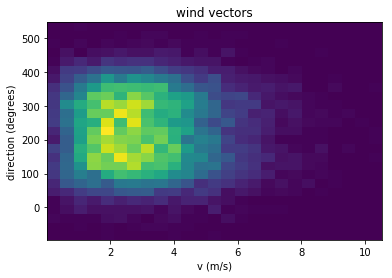

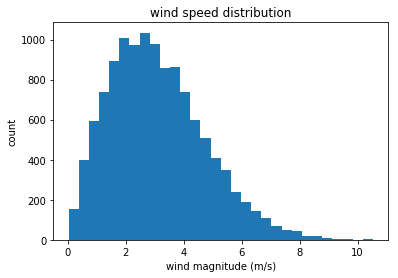

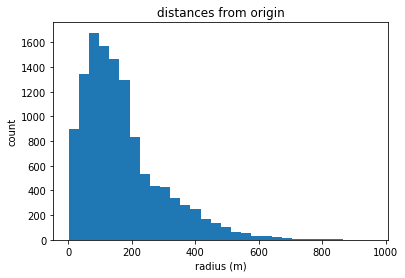

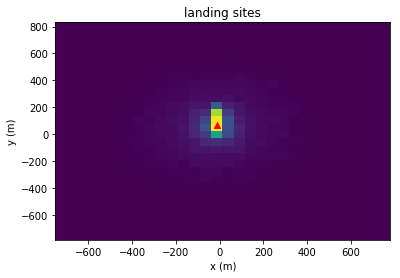

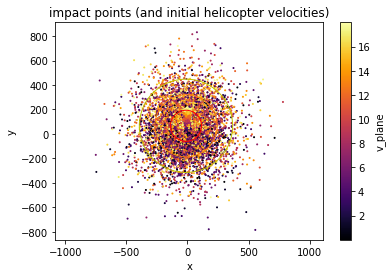

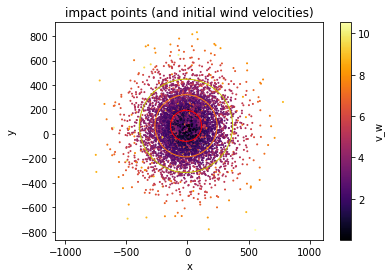

In [20]:
agg, agg_cep = visualize(aggregate)